## Setup Environment

Import useful libraries

In [4]:
!pip install --upgrade pip
!pip install pyspark==3.0

  Using cached pip-23.0.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.0
    Uninstalling pip-23.0:
      Successfully uninstalled pip-23.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 MB 10.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 26.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044167 sha256=c63c9cdd731b59e5d941d04acc528c8a00a9767ed36a0ca0a0bde970cb193a2e
  Stored in directory: /Users/alimokh/Library/Caches/pip/wheels/9f/e0/df/2efdf34f7caa61a5e9ac5c87932ceee2b469d25d28d9a50a5e
Successfully built pyspark


In [6]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F
import os
import seaborn as sns
import sklearn #
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib #
import matplotlib.pyplot as plt

In [8]:
os.environ["SPARK_LOCAL_IP"]='127.0.0.1'
spark = SparkSession.builder.master("local[*]").getOrCreate()
# build pyspark context and creat a Spark session: 
# creat a point of connection to the Spark engine, enabling the engine to run all of the code relating to Spark functionality.
spark.sparkContext._conf.getAll()
print("pyspark: {}".format(pyspark.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))

23/03/13 09:14:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


pyspark: 3.0.0
matplotlib: 3.6.2
seaborn: 0.12.2
sklearn: 1.1.3


Read dataset

In [9]:
# download data set. no need for Pandas
data_path = 'creditcard.csv'
df = spark.read.csv(data_path, header = True, inferSchema = True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove(labelColumn)
print(numericCols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [12]:
df.show(2)

23/03/13 09:32:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
|Time|              V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V14|              V15|               V16|               V17|               V18|               V19|                V20|               V21|               V22|               V23|       

Convert pyspark to pandas for comparison

In [13]:
df.toPandas().head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Processing

#### Create Feature vector

In [14]:
stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
dfFeatures = df.select(F.col(labelColumn).alias('label'),*numericCols )

#### Create normal and anomaly data

In [15]:
normal = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020) 
anomaly = dfFeatures.filter("Class == 1")

In [17]:
normal_train, normal_test = normal.randomSplit([0.8, 0.2],seed = 2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2],seed = 2020)

In [18]:
train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

### Create the Pipeline

Use a pipeline to create a feature vector from the data frame. This feature vector is what the logistic regression model will train on

In [19]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(dfFeatures)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)
selectedCols = ['label', 'features'] + numericCols
train = train.select(selectedCols)
test = test.select(selectedCols)
print("Training Dataset Count: ", train.count())
print("Test Dataset Count: ", test.count())

Training Dataset Count:  114389


Test Dataset Count:  28459


## Model Training

Define and train the model

In [20]:
lr = LogisticRegressionPySpark(featuresCol = 'features',labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
pyspark_auc_score = trainingSummary.areaUnderROC

23/03/13 10:37:48 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/13 10:37:48 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


## Model Evaluation

In [21]:
predictions = lrModel.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
evaluations = lrModel.evaluate(test)
accuracy = evaluations.accuracy

In [22]:
print(f"AUC Score: {roc_auc_score(y_pred, y_true):.3%}")
print(f"PySpark AUC Score: {pyspark_auc_score:.3%}")
print(f"Accuracy Score: {accuracy:.3%}")

AUC Score: 93.722%
PySpark AUC Score: 97.996%
Accuracy Score: 99.909%


plot some graphs

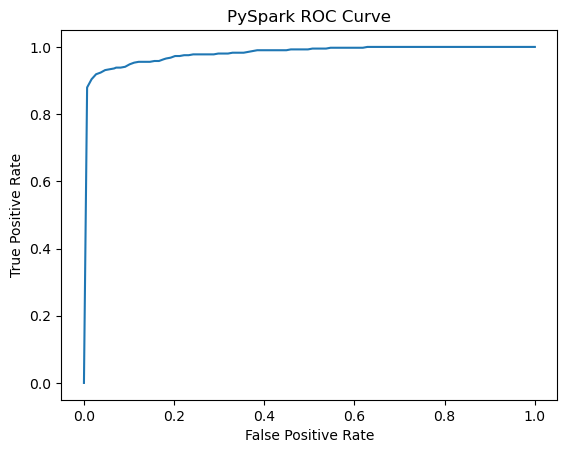

In [23]:
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'],pyspark_roc['TPR'])

### Confusion Matrix

Text(0.5, 23.52222222222222, 'Predicted')

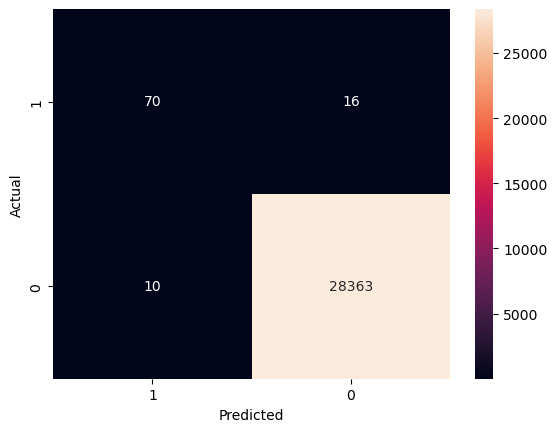

In [25]:
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g') 
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

The plotted confusion matrix of the PySpark logistic regression model you just trained. The accuracy of correctly labeled points for the normal data is very high and is decent for the anomalous data